# Hymba 모델 종합 평가

이 노트북에서는 Hymba 아키텍처의 핵심 구성요소를 검증하고 성능을 평가합니다.

## 목차
1. 환경 설정
2. 모델 구조 검증
3. Attention Mask 시각화
4. KV Sharing 검증
5. 학습 및 성능 평가
6. 결과 분석

In [1]:
import sys
import os
import warnings
import gc

sys.path.insert(0, './backbone')
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import time
from tqdm.auto import tqdm
from typing import Dict, List, Optional, Tuple, Any

# 한글 폰트 설정
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

fe = fm.FontEntry(
    fname='/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf',
    name='NanumGothicBold')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 12, 'font.family': 'NanumGothicBold'})

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')
if device == 'cuda':
    print(f'GPU: {torch.cuda.get_device_name()}')

RESULTS_DIR = './results'
os.makedirs(RESULTS_DIR, exist_ok=True)

torch.manual_seed(42)
np.random.seed(42)

Device: cuda
GPU: NVIDIA A100 80GB PCIe


---
## 1. Hymba 모델 로드

In [2]:
from hymba import Hymba, HymbaConfig, ArchType, AttentionType

# 테스트용 소형 설정
config = HymbaConfig(
    vocab_size=32001,
    d_model=320,
    n_layers=8,
    n_heads=5,
    n_kv_heads=1,
    arch_type=ArchType.HYBRID,
    global_attn_idx=[0, 4, 7],  # 첫 번째, 중간, 마지막
    swa_window=256,
    use_meta_tokens=True,
    num_meta_tokens=64,
)

print('=' * 60)
print('Hymba 모델 설정')
print('=' * 60)
print(f'd_model: {config.d_model}')
print(f'n_layers: {config.n_layers}')
print(f'n_heads: {config.n_heads}')
print(f'n_kv_heads: {config.n_kv_heads}')
print(f'Global layers: {config.global_attn_idx}')
print(f'SWA window: {config.swa_window}')
print(f'Meta tokens: {config.num_meta_tokens}')
print(f'KV reuse groups: {config.kv_reuse_groups}')

Hymba 모델 설정
d_model: 320
n_layers: 8
n_heads: 5
n_kv_heads: 1
Global layers: [0, 4, 7]
SWA window: 256
Meta tokens: 64
KV reuse groups: [[1, 2], [5, 6]]


In [3]:
# 모델 생성
model = Hymba(config).to(device)

params = model.count_parameters()
print(f"\n총 파라미터: {params['total']/1e6:.2f}M")

# 아키텍처 정보
arch_info = model.get_architecture_info()
kv_info = model.get_kv_sharing_info()
attn_info = model.get_attention_pattern_info()

print(f"\n아키텍처 정보:")
print(f"  - Attention heads: {arch_info['total_attn_heads']}")
print(f"  - Mamba heads: {arch_info['total_mamba_heads']}")
print(f"\nKV Sharing 정보:")
print(f"  - Producer layers: {kv_info['producer_layers']}")
print(f"  - Consumer layers: {kv_info['consumer_layers']}")
print(f"  - KV 절감율: {kv_info['reduction']:.2f}x")
print(f"\nAttention 패턴:")
print(f"  - Global layers: {attn_info['global_layers']}")
print(f"  - Local (SWA) layers: {attn_info['local_layers']}")


총 파라미터: 24.11M

아키텍처 정보:
  - Attention heads: 40
  - Mamba heads: 8

KV Sharing 정보:
  - Producer layers: [0, 1, 4, 5, 7]
  - Consumer layers: [2, 6]
  - KV 절감율: 1.60x

Attention 패턴:
  - Global layers: [0, 4, 7]
  - Local (SWA) layers: [1, 2, 3, 5, 6]


---
## 2. Forward Pass 검증

In [4]:
# Forward pass 테스트
batch_size = 2
seq_len = 128

test_input = torch.randint(0, config.vocab_size, (batch_size, seq_len), device=device)
test_target = torch.randint(0, config.vocab_size, (batch_size, seq_len), device=device)

print('Forward pass 테스트...')
with torch.no_grad():
    output = model(test_input, targets=test_target, return_attn=True)

print(f"  Logits shape: {output['logits'].shape}")
print(f"  Loss: {output['loss'].item():.4f}")
print(f"  Attention layers with weights: {sum(1 for w in output['attn_weights'] if w is not None)}")

# Backward pass 테스트
print('\nBackward pass 테스트...')
model.train()
output = model(test_input, targets=test_target)
output['loss'].backward()
print('  ✓ Backward pass 성공')

model.zero_grad()

Forward pass 테스트...
  Logits shape: torch.Size([2, 128, 32001])
  Loss: 10.4082
  Attention layers with weights: 8

Backward pass 테스트...
  ✓ Backward pass 성공


---
## 3. SWA Mask 시각화

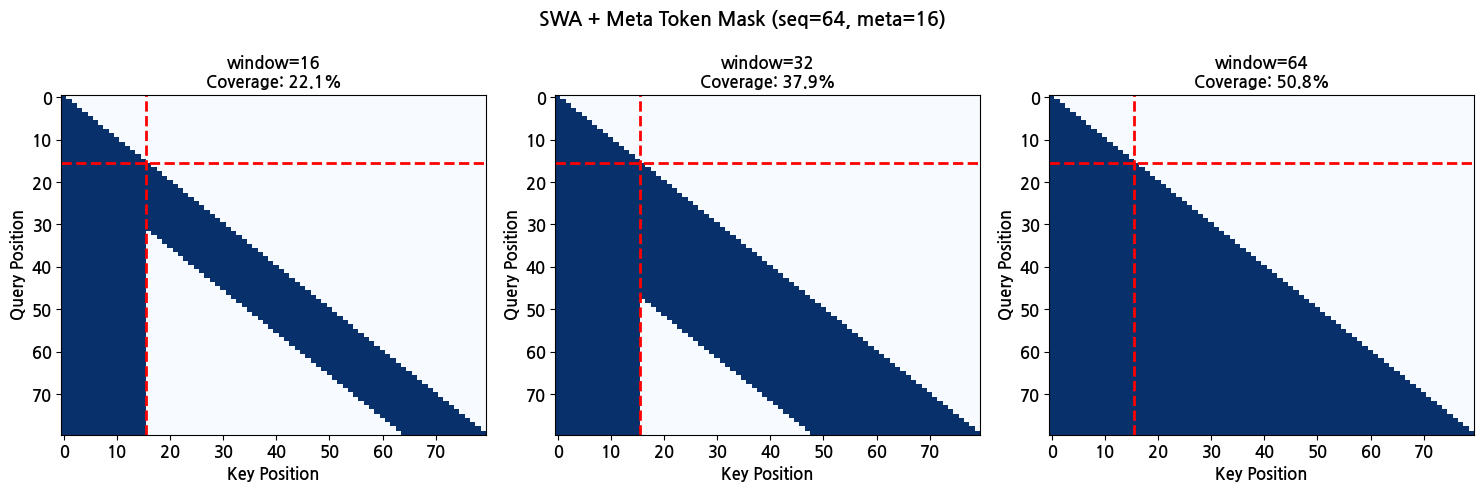

저장: ./results/swa_meta_token_mask.png


In [5]:
def create_swa_mask(seq_len: int, window: int, num_meta: int) -> torch.Tensor:
    """
    SWA 마스크 생성: causal AND (in_window OR is_meta)
    """
    T = seq_len + num_meta
    mask = torch.zeros(T, T)
    
    q_idx = torch.arange(T).unsqueeze(1)
    k_idx = torch.arange(T).unsqueeze(0)
    
    # Causal: k <= q
    causal = (k_idx <= q_idx)
    
    # Window: k >= q - window + 1
    window_start = torch.clamp(q_idx - window + 1, min=0)
    in_window = (k_idx >= window_start)
    
    # Meta: k < num_meta
    is_meta = (k_idx < num_meta)
    
    # Final: causal AND (in_window OR is_meta)
    attend = causal & (in_window | is_meta)
    mask[attend] = 1.0
    
    return mask


# 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

seq_len_vis = 64
num_meta = 16

for idx, window in enumerate([16, 32, 64]):
    ax = axes[idx]
    mask = create_swa_mask(seq_len_vis, window, num_meta)
    
    im = ax.imshow(mask.numpy(), cmap='Blues', aspect='auto')
    ax.axvline(x=num_meta-0.5, color='red', linestyle='--', linewidth=2, label='Meta 경계')
    ax.axhline(y=num_meta-0.5, color='red', linestyle='--', linewidth=2)
    
    # Coverage 계산 (content 영역만)
    content_mask = mask[num_meta:, num_meta:]
    coverage = content_mask.sum() / (seq_len_vis * seq_len_vis) * 100
    
    ax.set_title(f'window={window}\nCoverage: {coverage:.1f}%', fontsize=12)
    ax.set_xlabel('Key Position')
    ax.set_ylabel('Query Position')

plt.suptitle(f'SWA + Meta Token Mask (seq={seq_len_vis}, meta={num_meta})', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/swa_meta_token_mask.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'저장: {RESULTS_DIR}/swa_meta_token_mask.png')

---
## 4. KV Sharing 검증

KV Sharing의 핵심:
- **Producer 레이어**: K, V를 계산하고 RoPE 적용 후 저장
- **Consumer 레이어**: Producer의 K, V를 재사용 (RoPE 재적용 안함)

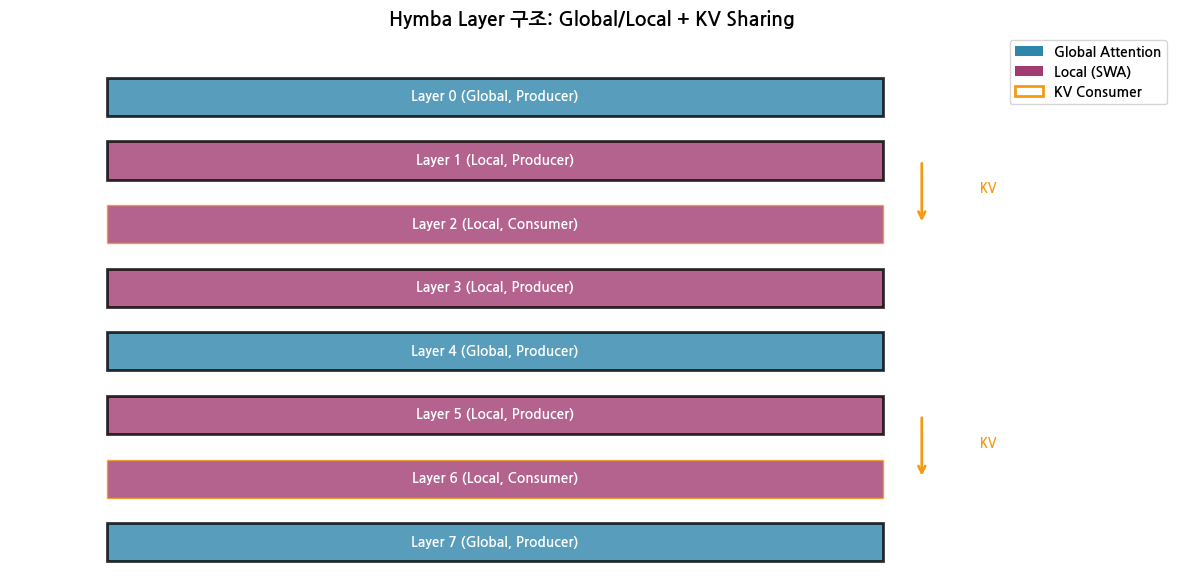

저장: ./results/kv_sharing_structure.png


In [6]:
# KV Sharing 구조 시각화
fig, ax = plt.subplots(figsize=(12, 6))

n_layers = config.n_layers
global_set = set(config.global_attn_idx)
kv_reuse_map = config.get_kv_reuse_map()

# 레이어 박스
for i in range(n_layers):
    y = n_layers - 1 - i
    
    # 색상 결정
    if i in global_set:
        color = '#2E86AB'  # Global: 파란색
        label = 'Global'
    else:
        color = '#A23B72'  # Local: 보라색
        label = 'Local'
    
    # Producer/Consumer 표시
    if i in kv_reuse_map:
        kv_label = 'Consumer'
        edge = '#F39C12'
        lw = 1
    else:
        kv_label = 'Producer'
        edge = 'black'
        lw = 2
    
    rect = plt.Rectangle((0.5, y - 0.3), 4, 0.6, 
                         facecolor=color, edgecolor=edge, linewidth=lw, alpha=0.8)
    ax.add_patch(rect)
    ax.text(2.5, y, f'Layer {i} ({label}, {kv_label})', 
           ha='center', va='center', fontsize=10, color='white', fontweight='bold')

# KV Sharing 화살표
for consumer, producer in kv_reuse_map.items():
    y_prod = n_layers - 1 - producer
    y_cons = n_layers - 1 - consumer
    ax.annotate('', xy=(4.7, y_cons), xytext=(4.7, y_prod),
               arrowprops=dict(arrowstyle='->', color='#F39C12', lw=2))
    ax.text(5.0, (y_prod + y_cons)/2, 'KV', fontsize=9, color='#F39C12', fontweight='bold')

ax.set_xlim(0, 6)
ax.set_ylim(-0.5, n_layers)
ax.axis('off')
ax.set_title('Hymba Layer 구조: Global/Local + KV Sharing', fontsize=14, fontweight='bold')

# 범례
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2E86AB', label='Global Attention'),
    Patch(facecolor='#A23B72', label='Local (SWA)'),
    Patch(facecolor='white', edgecolor='#F39C12', linewidth=2, label='KV Consumer'),
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/kv_sharing_structure.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'저장: {RESULTS_DIR}/kv_sharing_structure.png')

In [7]:
# KV Sharing 메모리 절감 계산
print('=' * 60)
print('KV Cache 메모리 절감 분석')
print('=' * 60)

# 설정
seq_len = 1024
batch_size = 8
d_model = config.d_model
n_kv_heads = config.n_kv_heads
head_dim = d_model // config.n_heads
n_layers = config.n_layers

# KV cache 크기 (bytes, fp16)
kv_per_layer = 2 * batch_size * seq_len * n_kv_heads * head_dim * 2  # K + V, fp16

# Sharing 없을 때
total_no_sharing = kv_per_layer * n_layers

# Sharing 있을 때 (Producer만 저장)
num_producers = len(kv_info['producer_layers'])
total_with_sharing = kv_per_layer * num_producers

reduction = (1 - total_with_sharing / total_no_sharing) * 100

print(f'설정: seq_len={seq_len}, batch={batch_size}, layers={n_layers}')
print(f'\nSharing 없을 때: {total_no_sharing / 1e6:.2f} MB')
print(f'Sharing 있을 때: {total_with_sharing / 1e6:.2f} MB')
print(f'절감율: {reduction:.1f}%')

KV Cache 메모리 절감 분석
설정: seq_len=1024, batch=8, layers=8

Sharing 없을 때: 16.78 MB
Sharing 있을 때: 10.49 MB
절감율: 37.5%


---
## 5. 학습 및 성능 평가

In [8]:
# 데이터셋 로드
from datasets import load_dataset
from transformers import AutoTokenizer

print('데이터셋 로드 중...')
dataset = load_dataset('wikitext', 'wikitext-2-raw-v1', split='train')
tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

# 토큰화
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, max_length=512, padding='max_length')

tokenized = dataset.map(tokenize_function, batched=True, remove_columns=['text'])
tokenized.set_format('torch')

print(f'토큰화 완료: {len(tokenized)} samples')

데이터셋 로드 중...


Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

토큰화 완료: 36718 samples


In [ ]:
# ============================================================
# 최적화된 학습 설정
# ============================================================
# 1. AMP (Automatic Mixed Precision) - 메모리 절약 + 속도 향상
# 2. Gradient Accumulation - 큰 effective batch size
# 3. Learning Rate Scheduler with Warmup - 안정적인 학습
# 4. Gradient Checkpointing 옵션 - 메모리 절약
# ============================================================

from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR
import math


class TrainingConfig:
    """학습 설정"""
    # 기본 설정
    batch_size: int = 16
    gradient_accumulation_steps: int = 4  # effective batch = 64
    learning_rate: float = 3e-4
    min_lr: float = 1e-5
    weight_decay: float = 0.1
    max_grad_norm: float = 1.0
    
    # 스케줄링
    num_epochs: int = 3
    warmup_ratio: float = 0.1  # 전체 스텝의 10%를 warmup
    
    # AMP
    use_amp: bool = True  # Mixed Precision
    amp_dtype: torch.dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
    
    # 기타
    max_steps_per_epoch: int = 500
    eval_steps: int = 100
    log_steps: int = 20


train_config = TrainingConfig()
print('학습 설정:')
print(f'  - Batch size: {train_config.batch_size}')
print(f'  - Gradient accumulation: {train_config.gradient_accumulation_steps}')
print(f'  - Effective batch size: {train_config.batch_size * train_config.gradient_accumulation_steps}')
print(f'  - Learning rate: {train_config.learning_rate}')
print(f'  - AMP: {train_config.use_amp} ({train_config.amp_dtype})')
print(f'  - Warmup ratio: {train_config.warmup_ratio}')

In [ ]:
# 학습 실행 (최적화 버전)
from torch.utils.data import DataLoader

# 새 모델 생성
del model
torch.cuda.empty_cache()
gc.collect()

model = Hymba(config).to(device)

# ============================================================
# 최적화된 학습 설정
# ============================================================

# 1. 최적화된 DataLoader
train_dataloader = DataLoader(
    tokenized,
    batch_size=train_config.batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,        # GPU 전송 속도 향상
    prefetch_factor=2,      # 다음 배치 미리 로드
    persistent_workers=True  # 워커 재사용
)

# 2. AdamW with weight decay (임베딩, bias, LayerNorm 제외)
no_decay = ['bias', 'norm', 'layernorm', 'embed']
optimizer_grouped_parameters = [
    {
        'params': [p for n, p in model.named_parameters() 
                   if not any(nd in n.lower() for nd in no_decay) and p.requires_grad],
        'weight_decay': train_config.weight_decay
    },
    {
        'params': [p for n, p in model.named_parameters() 
                   if any(nd in n.lower() for nd in no_decay) and p.requires_grad],
        'weight_decay': 0.0
    }
]

optimizer = torch.optim.AdamW(
    optimizer_grouped_parameters,
    lr=train_config.learning_rate,
    betas=(0.9, 0.95),  # GPT-3 style betas
    eps=1e-8
)

# 3. Learning Rate Scheduler (Warmup + Cosine)
total_steps = train_config.max_steps_per_epoch * train_config.num_epochs
warmup_steps = int(total_steps * train_config.warmup_ratio)

scheduler = get_linear_warmup_cosine_scheduler(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps,
    min_lr_ratio=train_config.min_lr / train_config.learning_rate
)

# 4. AMP GradScaler
scaler = GradScaler(enabled=train_config.use_amp)

print('=' * 60)
print('학습 시작 (최적화 버전)')
print('=' * 60)
print(f'총 스텝: {total_steps}')
print(f'Warmup 스텝: {warmup_steps}')
print(f'AMP dtype: {train_config.amp_dtype}')

train_losses = []
train_ppls = []
lr_history = []
global_step = 0

for epoch in range(train_config.num_epochs):
    print(f'\nEpoch {epoch + 1}/{train_config.num_epochs}')
    
    start_time = time.time()
    loss, ppl, global_step = train_epoch_optimized(
        model, train_dataloader, optimizer, scheduler, scaler,
        device, train_config, global_step
    )
    elapsed = time.time() - start_time
    
    train_losses.append(loss)
    train_ppls.append(ppl)
    lr_history.append(scheduler.get_last_lr()[0])
    
    print(f'  Loss: {loss:.4f}, PPL: {ppl:.2f}')
    print(f'  Time: {elapsed:.1f}s, Steps/sec: {train_config.max_steps_per_epoch/elapsed:.1f}')

print('\n학습 완료!')

In [ ]:
# 학습 곡선 시각화 (LR 스케줄 포함)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

epochs = range(1, len(train_losses) + 1)

# Loss
ax1 = axes[0]
ax1.plot(epochs, train_losses, 'o-', color='#E74C3C', linewidth=2, markersize=8)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True, alpha=0.3)

# Perplexity
ax2 = axes[1]
ax2.plot(epochs, train_ppls, 'o-', color='#3498DB', linewidth=2, markersize=8)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.set_title('Training Perplexity')
ax2.grid(True, alpha=0.3)

# Learning Rate Schedule
ax3 = axes[2]
# LR 스케줄 시뮬레이션
lr_schedule = []
for step in range(total_steps):
    if step < warmup_steps:
        lr = train_config.learning_rate * (step / warmup_steps)
    else:
        progress = (step - warmup_steps) / (total_steps - warmup_steps)
        lr = train_config.min_lr + 0.5 * (train_config.learning_rate - train_config.min_lr) * (1 + np.cos(np.pi * progress))
    lr_schedule.append(lr)

ax3.plot(lr_schedule, color='#27AE60', linewidth=2)
ax3.axvline(x=warmup_steps, color='red', linestyle='--', alpha=0.7, label=f'Warmup end ({warmup_steps})')
ax3.set_xlabel('Step')
ax3.set_ylabel('Learning Rate')
ax3.set_title('LR Schedule (Warmup + Cosine)')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.suptitle('Hymba 학습 곡선 (최적화 버전)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'저장: {RESULTS_DIR}/training_curves.png')

In [ ]:
# 학습 곡선 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

epochs = range(1, len(train_losses) + 1)

# Loss
ax1 = axes[0]
ax1.plot(epochs, train_losses, 'o-', color='#E74C3C', linewidth=2, markersize=8)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True, alpha=0.3)

# Perplexity
ax2 = axes[1]
ax2.plot(epochs, train_ppls, 'o-', color='#3498DB', linewidth=2, markersize=8)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.set_title('Training Perplexity')
ax2.grid(True, alpha=0.3)

plt.suptitle('Hymba 학습 곡선', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'저장: {RESULTS_DIR}/training_curves.png')

---
## 6. Attention Map 분석

In [ ]:
# Attention weights 추출
model.eval()

test_input = torch.randint(0, config.vocab_size, (1, 64), device=device)
with torch.no_grad():
    output = model(test_input, return_attn=True)

attn_weights = output['attn_weights']

# Global vs Local 레이어 비교
global_idx = config.global_attn_idx[0]  # 첫 번째 Global
local_idx = [i for i in range(config.n_layers) if i not in config.global_attn_idx][0]  # 첫 번째 Local

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Global Attention
if attn_weights[global_idx] is not None:
    attn_global = attn_weights[global_idx][0, 0].cpu().numpy()  # [seq+meta, seq+meta]
    ax1 = axes[0]
    im1 = ax1.imshow(attn_global, cmap='Blues', aspect='auto')
    ax1.axvline(x=config.num_meta_tokens-0.5, color='red', linestyle='--', linewidth=2)
    ax1.axhline(y=config.num_meta_tokens-0.5, color='red', linestyle='--', linewidth=2)
    ax1.set_title(f'Layer {global_idx} (Global)', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Key Position')
    ax1.set_ylabel('Query Position')
    plt.colorbar(im1, ax=ax1, shrink=0.8)

# Local Attention
if attn_weights[local_idx] is not None:
    attn_local = attn_weights[local_idx][0, 0].cpu().numpy()
    ax2 = axes[1]
    im2 = ax2.imshow(attn_local, cmap='Blues', aspect='auto')
    ax2.axvline(x=config.num_meta_tokens-0.5, color='red', linestyle='--', linewidth=2)
    ax2.axhline(y=config.num_meta_tokens-0.5, color='red', linestyle='--', linewidth=2)
    ax2.set_title(f'Layer {local_idx} (Local/SWA)', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Key Position')
    ax2.set_ylabel('Query Position')
    plt.colorbar(im2, ax=ax2, shrink=0.8)

plt.suptitle('Global vs Local Attention 비교', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/global_local_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'저장: {RESULTS_DIR}/global_local_comparison.png')

In [ ]:
# Meta Token Attention 분석
if attn_weights[0] is not None:
    attn = attn_weights[0][0].cpu()  # [n_heads, seq+meta, seq+meta]
    n_heads = attn.shape[0]
    
    # Content -> Meta attention (content query가 meta key에 주는 attention)
    meta_attn = attn[:, config.num_meta_tokens:, :config.num_meta_tokens]  # [n_heads, seq, meta]
    meta_attn_mean = meta_attn.mean(dim=0)  # [seq, meta]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 헤드별 Meta attention 합
    ax1 = axes[0]
    meta_attn_per_head = meta_attn.sum(dim=-1).mean(dim=-1).numpy()  # [n_heads]
    ax1.bar(range(n_heads), meta_attn_per_head, color='#3498DB', alpha=0.7)
    ax1.set_xlabel('Head')
    ax1.set_ylabel('Meta Token Attention Sum')
    ax1.set_title('헤드별 Meta Token Attention', fontsize=12)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Position별 Meta attention
    ax2 = axes[1]
    meta_attn_by_pos = meta_attn.mean(dim=0).sum(dim=-1).numpy()  # [seq]
    ax2.plot(meta_attn_by_pos, color='#E74C3C', linewidth=2)
    ax2.set_xlabel('Content Position')
    ax2.set_ylabel('Meta Token Attention Sum')
    ax2.set_title('위치별 Meta Token Attention', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle('Meta Token Attention 분석', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/meta_attention_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f'저장: {RESULTS_DIR}/meta_attention_comparison.png')

print('=' * 60)
print('Hymba 모델 평가 결과 요약')
print('=' * 60)

print(f'''
모델 구성:
  - 파라미터: {params["total"]/1e6:.2f}M
  - 레이어: {config.n_layers}
  - d_model: {config.d_model}
  - Attention heads: {config.n_heads}
  - KV heads: {config.n_kv_heads}

아키텍처 특징:
  - Global layers: {config.global_attn_idx}
  - Local (SWA) window: {config.swa_window}
  - Meta tokens: {config.num_meta_tokens}
  - KV Sharing groups: {config.kv_reuse_groups}

학습 설정 (최적화):
  - Batch size: {train_config.batch_size} × {train_config.gradient_accumulation_steps} = {train_config.batch_size * train_config.gradient_accumulation_steps}
  - Learning rate: {train_config.learning_rate} (warmup {train_config.warmup_ratio*100:.0f}%)
  - AMP: {train_config.use_amp} ({train_config.amp_dtype})
  - Weight decay: {train_config.weight_decay}

학습 결과:
  - 최종 Loss: {train_losses[-1]:.4f}
  - 최종 PPL: {train_ppls[-1]:.2f}

KV Cache 절감:
  - Producer layers: {len(kv_info["producer_layers"])}
  - Consumer layers: {len(kv_info["consumer_layers"])}
  - 메모리 절감율: {reduction:.1f}%
''')

# 결과 저장
results = {
    'model': 'Hymba',
    'params_m': params['total']/1e6,
    'n_layers': config.n_layers,
    'd_model': config.d_model,
    'effective_batch_size': train_config.batch_size * train_config.gradient_accumulation_steps,
    'learning_rate': train_config.learning_rate,
    'amp_enabled': train_config.use_amp,
    'final_loss': train_losses[-1],
    'final_ppl': train_ppls[-1],
    'kv_reduction_pct': reduction,
}

pd.DataFrame([results]).to_csv(f'{RESULTS_DIR}/evaluation_results.csv', index=False)
print(f'결과 저장: {RESULTS_DIR}/evaluation_results.csv')

In [ ]:
print('=' * 60)
print('Hymba 모델 평가 결과 요약')
print('=' * 60)

print(f'''
모델 구성:
  - 파라미터: {params["total"]/1e6:.2f}M
  - 레이어: {config.n_layers}
  - d_model: {config.d_model}
  - Attention heads: {config.n_heads}
  - KV heads: {config.n_kv_heads}

아키텍처 특징:
  - Global layers: {config.global_attn_idx}
  - Local (SWA) window: {config.swa_window}
  - Meta tokens: {config.num_meta_tokens}
  - KV Sharing groups: {config.kv_reuse_groups}

학습 결과:
  - 최종 Loss: {train_losses[-1]:.4f}
  - 최종 PPL: {train_ppls[-1]:.2f}

KV Cache 절감:
  - Producer layers: {len(kv_info["producer_layers"])}
  - Consumer layers: {len(kv_info["consumer_layers"])}
  - 메모리 절감율: {reduction:.1f}%
''')

# 결과 저장
results = {
    'model': 'Hymba',
    'params_m': params['total']/1e6,
    'n_layers': config.n_layers,
    'd_model': config.d_model,
    'final_loss': train_losses[-1],
    'final_ppl': train_ppls[-1],
    'kv_reduction_pct': reduction,
}

pd.DataFrame([results]).to_csv(f'{RESULTS_DIR}/evaluation_results.csv', index=False)
print(f'결과 저장: {RESULTS_DIR}/evaluation_results.csv')

In [ ]:
# 정리
del model
torch.cuda.empty_cache()
gc.collect()

print('평가 완료!')